# Приоритизация гипотез для увеличения выручки и проведение A/B теста

## Описание проекта

Отдел маркетинга крупного интернет-магазина подготовил список гипотез для увеличения выручки. 

**Задачи данного исследования**: 
* приоритизировать гипотезы; 
* запустить A/B-тест; 
* проанализировать результаты.

В нашем распоряжении есть данные о покупках и визитах пользователей, а также файл с описанием гипотез.

**Ход исследования:**

В первую очередь загрузим данные из csv-файлов с информацией о посещениях сайта, о покупках пользователей и о гипотезах. Далее выполним этап предобработки: посмотрим датафреймы на наличие явных и неявных дубликатов, пропусков и аномалий. Изменим тип значений в столбцах, где это необходимо. После этого проведём проверку групп A и B на однородность данных, сравним их размеры и поищем пользователей, которые могли попасть сразу в обе группы. Затем приоритизируем наши гипотезы с помощью фреймворков RICE и ICE. На главном этапе исследования изучим графики куммулятивных метрик, определим аномальных клиентов по количеству заказов и их стоимости, посчитаем статистическую значимость различий в среднем чеке и среднем количестве заказов между группами по "сырым" и "очищенным" данным. В конце примем решение по результатам теста.  

## Изучение файлов с данными

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats as st
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
# импорт библиотек pandas, seaborn, matplotlib.pyplot, numpy, stats
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth=150

In [2]:
hypothesis_df = pd.read_csv('/Users/polzovatel/Desktop/Проекты Яндекс доработка/Online shop A:B test/hypothesis.csv')
orders_df = pd.read_csv('/Users/polzovatel/Desktop/Проекты Яндекс доработка/Online shop A:B test/orders.csv')
visitors_df = pd.read_csv('/Users/polzovatel/Desktop/Проекты Яндекс доработка/Online shop A:B test/visitors.csv')
# сохранение файлов с данными в переменные hypothesis_df, orders_df, visitors_df 

In [3]:
def get_df_info(df):
    display(df.head(10))
    display(df.info())
    display(df.describe())
# создание функции для вывода характеристик датафреймов

In [4]:
for name, df in {'hypothesis_df':hypothesis_df, 'orders_df':orders_df, 'visitors_df':visitors_df}.items():
    print(f'Характеристики датафрейма: {name}')
    get_df_info(df)
# применение функции get_df_info(df) с использованием цикла

Характеристики датафрейма: hypothesis_df


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Характеристики датафрейма: orders_df


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Характеристики датафрейма: visitors_df


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


В первую очередь следует перевести названия столбцов датафрейма **hypothesis_df** в нижний регистр. Затем проверить информацию в таблицах на наличие явных и неявных дубликатов. Далее нужно поменять тип дат в колонках `date` датафреймов **orders_df и visitors_df**. На последнем этапе предобработки посмотрим, есть ли аномалии в данных. Стоит дополнительно отметить, что пропусков в данных нет. 

**Вывод:**

В каждой строке таблицы **hypothesis_df** — данные с кратким описанием гипотезы и оценкой парметров *Reach* (охват пользователей), *Impact* (степень влияния на пользователей), *Confidence* (уверенность в гипотезе) и *Efforts* (стоимость тестирования гипотезы) по 10-бальной шкале. 

Датафрейм **orders_df** содержит статистику по заказам пользователей и включает дату покупки, её стоимость и группу A/B теста, куда попал заказ.

Общее число пользователей, агрегированных по дням и распределённых по группам A/B теста, представлено в таблице **visitors_df**.

На первый взгляд, в колонке `revenue` присутствуют выбросы. График распределения поможет визуально определить аномалии в данных. Также следует исправить названия столбцов, преобразовать даты и время в нужный тип и провести поиск полных и неявных дубликатов.

## Предобработка данных

### Замена названий столбцов

In [5]:
hypothesis_df.columns = hypothesis_df.columns.str.lower()
# преобразование названий колонок в строчные символы

In [6]:
hypothesis_df.head()
# вывод первых 5 строк датафрейма hypothesis_df

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


### Проверка на дубликаты

In [7]:
for name, df in {'hypothesis_df':hypothesis_df, 'orders_df':orders_df, 'visitors_df':visitors_df}.items():
    print(f'Количество явных дубликатов в датафрейме: {name}')
    print(df.duplicated().sum())
    print('')
# подсчёт явных дубликатов

Количество явных дубликатов в датафрейме: hypothesis_df
0

Количество явных дубликатов в датафрейме: orders_df
0

Количество явных дубликатов в датафрейме: visitors_df
0



Явных дубликатов тоже нет, удалять нечего.

In [8]:
orders_df['group'].value_counts()
# количество уникальных совпадений в колонке 'group' датафрейма orders_df

B    640
A    557
Name: group, dtype: int64

In [9]:
visitors_df['group'].value_counts()
# количество уникальных совпадений в колонке 'group' датафрейма visitors_df

A    31
B    31
Name: group, dtype: int64

### Изменение типов данных

In [10]:
for df in [orders_df, visitors_df]:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.date
# приведение столбцов с датами к нужному формату datetime

### Проверка на аномалии

Проверим, совпадают ли временные интервалы в датафреймах **orders_df и visitors_df**.

In [11]:
print(f'Начало периода в таблице orders_df — {orders_df["date"].min()} и конец — {orders_df["date"].max()}')
# вывод временного периода orders_df

Начало периода в таблице orders_df — 2019-08-01 и конец — 2019-08-31


In [12]:
print(f'Начало периода в таблице visitors_df — {visitors_df["date"].min()} и конец — {visitors_df["date"].max()}')
# вывод временного периода visitors_df

Начало периода в таблице visitors_df — 2019-08-01 и конец — 2019-08-31


In [13]:
matplotlib.rcParams['font.family'] = 'sans-serif'
def show_distribution_graphs(df, column, title, ylim=[0, 40000], number_of_bins=30, range_of_values=(0, 25000)):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
    ax2.grid(which='major', linewidth=1, color='gray',  alpha=0.2)
    ax2.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.tick_params(which='minor', length=2, width=1)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.xaxis.set_visible(False)
    
    fig.suptitle(f'Гистограмма и диаграмма размаха параметра: {title}', fontsize=15, color='#0C0C6D')

    df.boxplot(
               column, 
               ax=ax1,
               widths=0.3,
               showmeans=True, 
               meanline=True, 
               color='#40393A', 
               flierprops=dict(marker='D', markerfacecolor='white', markeredgecolor='#640F64', linewidth=2),
               medianprops=dict(linewidth=1.7, color='maroon'),
               boxprops=dict(linewidth=1.5),
               meanprops=dict(linewidth=1.5, color='#3232A6')
              ).set_ylim(ylim)
    df.hist(column, ax=ax2, bins=number_of_bins, range=range_of_values, color='#CC7565')
    ax2.set_title(None)
    
    fig.tight_layout()
    return plt.show()
# создание функции для построения графиков распределения величин: гистограммы и диаграммы размаха

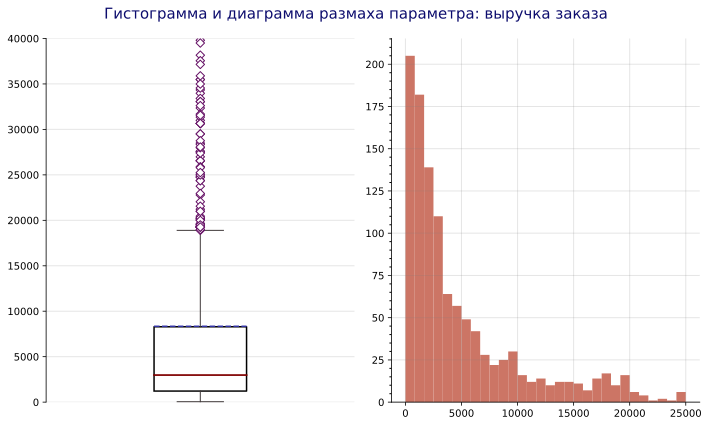

In [14]:
show_distribution_graphs(orders_df, 'revenue', 'выручка заказа')
# вывод графиков распределения стоимостей заказов

На графике есть много одиночных выбросов, заказы на сумму больше 19 тыс. ед. Среднее сильно смещено вверх на уровень третьего квартиля Q3. Это значит, что самые дорогие покупки сильно влияют на среднее и искажают данные. Например, в датафреме **orders_df** максимальная стоимость заказа составляет *1 294 500 ед.*, при том, что **медиана** равна *2 978 ед*.

Далее по ходу исследования мы сделаем очистку данных и удалим пользователей с аномально высокой стоимостью заказов.

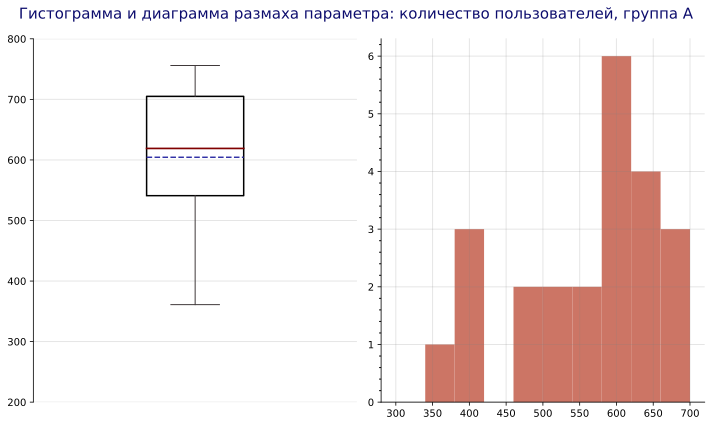

In [15]:
show_distribution_graphs(visitors_df.query('group == "A"'), 
                         'visitors', 
                         'количество пользователей, группа А',
                         ylim=[200, 800], 
                         number_of_bins=10, 
                         range_of_values=(300, 700)
                        )
# вывод графиков распределения количества пользователей в группе А

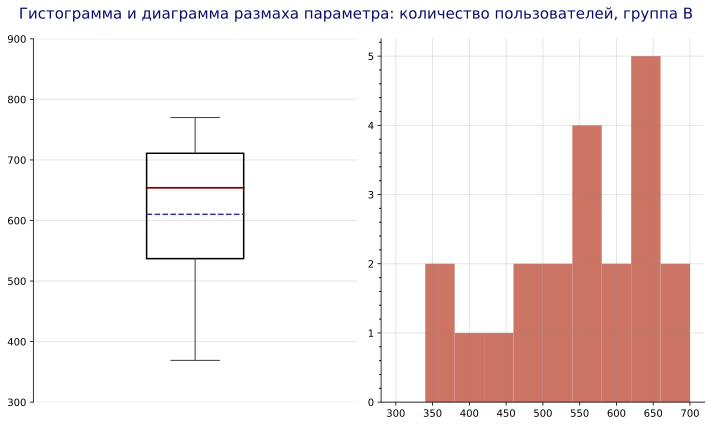

In [16]:
show_distribution_graphs(visitors_df.query('group == "B"'), 
                         'visitors', 
                         'количество пользователей, группа В',
                         ylim=[300, 900], 
                         number_of_bins=10, 
                         range_of_values=(300, 700)
                        )
# вывод графиков распределения количества пользователей в группе В

Среднее число посетителей для обоих сегментов практически совпадает (около *605* клиентов). Медиана группы B расположена немного выше медианы A с разницей в 35 пользователей. В целом, графики распределений **схожи**.

## Проверка групп A/B на однородность

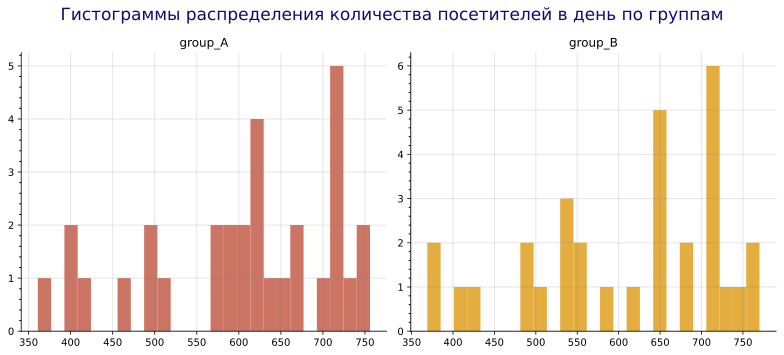

In [17]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='minor', length=2, width=1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='minor', length=2, width=1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
  
fig.suptitle('Гистограммы распределения количества посетителей в день по группам', fontsize=17, color='#0C0C6D')

(visitors_df
    .query('group == "A"')
    .hist('visitors', ax=ax1, bins=25, color='#CC7565', label='group_A')
) 

(visitors_df
    .query('group == "B"')
    .hist('visitors', ax=ax2, bins=25, color='#E3AD40', label='group_B')
) 
    
ax1.set_title('group_A')
ax2.set_title('group_B')
fig.tight_layout()
plt.show()
# вывод графиков распределения количества посетителей в день по группам

In [18]:
print('Среднее количество посететилей группы A в день: {0}'.format(int(visitors_df.query('group == "A"')['visitors'].mean())))
print('Среднее количество посететилей группы B в день: {0}'.format(int(visitors_df.query('group == "B"')['visitors'].mean())))

Среднее количество посететилей группы A в день: 604
Среднее количество посететилей группы B в день: 610


In [19]:
print('Количество посетителей в группе А: {0}'.format((visitors_df.query('group == "A"')['visitors'].sum())))
print('Количество посетителей в группе B: {0}'.format((visitors_df.query('group == "B"')['visitors'].sum())))

Количество посетителей в группе А: 18736
Количество посетителей в группе B: 18916


In [20]:
print('Среднее число покупок в группе A: {0}'.format(orders_df.query('group == "A"')['transactionId'].nunique()))
print('Среднее число покупок в группе B: {0}'.format(orders_df.query('group == "B"')['transactionId'].nunique()))

Среднее число покупок в группе A: 557
Среднее число покупок в группе B: 640


In [21]:
print('Среднее число уникальных покупателей в группе A: {0}'.format(orders_df.query('group == "A"')['visitorId'].nunique()))
print('Среднее число уникальных покупателей в группе B: {0}'.format(orders_df.query('group == "B"')['visitorId'].nunique()))

Среднее число уникальных покупателей в группе A: 503
Среднее число уникальных покупателей в группе B: 586


In [22]:
transactions_per_visitors = (orders_df
                    .groupby('visitorId', as_index=False)
                    .agg({'transactionId': 'nunique', 'group': 'max'})
                    .sort_values(by='transactionId', ascending=False)
                   )
transactions_per_visitors.columns = ['visitorId','transactions_count', 'group']
transactions_per_visitors
# создание сводной таблицы с числом заказов на каждого покупателя

,visitorId,transactions_count,group
1023,4256040402,11,B
591,2458001652,11,B
569,2378935119,9,B
487,2038680547,8,B
44,199603092,5,B
...,...,...,...
359,1484903144,1,A
360,1485964287,1,A
361,1494664757,1,B
362,1495112755,1,A


In [23]:
print('Среднее число заказов на посетителя в группе A: {0}'.format(round(transactions_per_visitors.query('group == "A"')['transactions_count'].mean(), 1)))
print('Среднее число заказов на посетителя в группе B: {0}'.format(round(transactions_per_visitors.query('group == "B"')['transactions_count'].mean(), 1)))

Среднее число заказов на посетителя в группе A: 1.1
Среднее число заказов на посетителя в группе B: 1.2


In [24]:
print('Средняя сумма заказа в группе A: {0}'.format(round(orders_df.query('group == "A"')['revenue'].mean(), 2)))
print('Средняя сумма заказа в группе B: {0}'.format(round(orders_df.query('group == "B"')['revenue'].mean(), 2)))

Средняя сумма заказа в группе A: 7333.58
Средняя сумма заказа в группе B: 9230.88


In [25]:
result_stat = st.mannwhitneyu(visitors_df[visitors_df['group']=='A']['visitors'], visitors_df[visitors_df['group']=='B']['visitors'])
alpha = 0.05
print('p-value: {0}'.format(result_stat.pvalue))
print('')
if result_stat.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима.')
else:
    print('Разница в количестве посетителей в группах A и B статистически не значима.')

p-value: 0.7301376549390499

Разница в количестве посетителей в группах A и B статистически не значима.


**Вывод:** 

Несмотря на то, что между группами есть отличия в среднем числе покупок и средней сумме заказа (следует учесть влияние выбросов на данные метрики), относительная разница в количестве посетителей (B к A) — *менее 1%*. Более того, разница в количестве посетителей в группах A и B статистически **не значима**, а значит группы **однородны**.

## Проверка групп A/B на пересечение пользователей

In [26]:
print(orders_df.query('group == "A"')['visitorId'].nunique())
print(orders_df.query('group == "B"')['visitorId'].nunique())
# вывод числа уникальных посетителей в группах A и B

503
586


In [27]:
unique_A_visitors_transactions = orders_df.query('group == "A"')['visitorId'].unique()
unique_B_visitors_transactions = orders_df.query('group == "B"')['visitorId'].unique()
intersect_visitors = list(set(unique_A_visitors_transactions) & set(unique_B_visitors_transactions))
# создание переменной intersect_visitors с пользователями, которые попали в обе группы сразу

In [28]:
print(intersect_visitors)
print('')
print(f'Количество пользователей, которые попали в обе группы: {len(intersect_visitors)}')

[3957174400, 3984495233, 2780786433, 1294878855, 1648269707, 1614305549, 4120364173, 232979603, 199603092, 4266935830, 2712142231, 2587333274, 2716752286, 3891541246, 1668030113, 2654030115, 3234906277, 1230306981, 1404934699, 3803269165, 2949041841, 237748145, 457167155, 2927087541, 1738359350, 3062433592, 3656415546, 818047933, 393266494, 963407295, 471551937, 2579882178, 3202540741, 2686716486, 1333886533, 2044997962, 3941795274, 1801183820, 2378935119, 4256040402, 4069496402, 3766097110, 8300375, 351125977, 1602967004, 276558944, 2038680547, 3951559397, 3963646447, 4186807279, 3717692402, 1959144690, 2458001652, 2600415354, 2954449915, 1316129916, 477780734, 3972127743]

Количество пользователей, которые попали в обе группы: 58


Посмотрим подробнее на этих пользователей.

In [29]:
intersect_df = orders_df.query('visitorId in @intersect_visitors')
intersect_df
# вывод среза данных

,transactionId,visitorId,date,revenue,group
2,2961555356,4069496402,2019-08-15,400,A
20,2904772834,963407295,2019-08-15,300,B
23,4252514150,351125977,2019-08-15,15185,B
24,1162046357,3234906277,2019-08-15,7555,B
26,2223239646,199603092,2019-08-15,3488,A
...,...,...,...,...,...
1182,2682156369,1668030113,2019-08-14,1290,B
1183,1458356232,963407295,2019-08-14,4940,A
1184,1329499668,2949041841,2019-08-14,10380,B
1189,4082620617,393266494,2019-08-14,31550,B


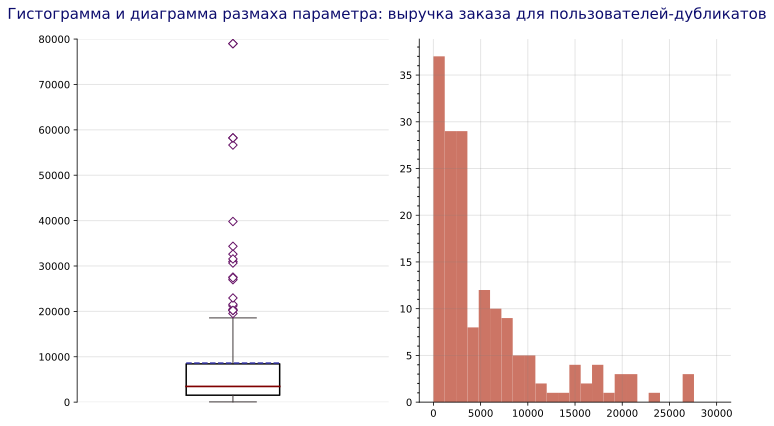

In [30]:
show_distribution_graphs(intersect_df, 
                         'revenue', 
                         'выручка заказа для пользователей-дубликатов',
                         ylim=[0, 80000], 
                         number_of_bins=25, 
                         range_of_values=(0, 30000)  
                        )
# вывод графиков распределения стоимостей заказов для дублирующихся пользователей

In [31]:
(intersect_df
            .groupby('visitorId', as_index=False)
            .agg({'transactionId': 'nunique'})
            .sort_values(by='transactionId', ascending=False)
            .head(20)
)
# создание сводной таблицы с числом заказов на каждого "покупателя-дубликата"

,visitorId,transactionId
56,4256040402,11
27,2458001652,11
26,2378935119,9
24,2038680547,8
12,1230306981,5
3,237748145,5
39,3062433592,5
1,199603092,5
43,3717692402,5
45,3803269165,5


**Вывод:**

С одной стороны, пользователи, которые участвуют в обеих группах, не позволят провести корректное сравнение метрик при оценке статистической значимости: невозможно точно установить, повлияла ли новая фича на клиента или это его типичное поведение. При этом в нашем случае удаление таких пользователей может повлиять на расчёт конверсии, так как убрать их из таблицы **visits_df** мы не сможем из-за агрегированности данных в столбце `visits`. Можно заметить, что среди пересекающихся Id есть часть покупателей с большим числом заказов и очень дорогими покупками. В дальнейшем они будут отсеяны на этапе очистки данных и поэтому сейчас **удалять их мы не будем**. 

## Приоритизация гипотез

### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [32]:
hypothesis_df['ice_score'] = round(hypothesis_df['impact'] * hypothesis_df['confidence'] / hypothesis_df['efforts'], 1)
# создание столбца с параметром ICE

In [33]:
hypothesis_df[['hypothesis', 'ice_score']].sort_values(by='ice_score', ascending=False)
# сортировка гипотез по параметру ICE по убыванию

,hypothesis,ice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [34]:
hypothesis_df['rice_score'] = round(hypothesis_df['reach'] * hypothesis_df['impact'] * hypothesis_df['confidence'] / hypothesis_df['efforts'], 1)
# создание столбца с параметром RICE

In [35]:
hypothesis_df[['hypothesis', 'ice_score', 'rice_score', 'reach']].sort_values(by='rice_score', ascending=False)
# сортировка гипотез по параметру RICE по убыванию

,hypothesis,ice_score,rice_score,reach
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,112.0,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,56.0,8
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,40.0,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,40.0,5
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2,1
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,9.0,8
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,4.0,2
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,4.0,3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,3.0,3


При оценке по фреймворку **ICE** формируется Топ-3: гипотезы с индексами 8, 0 и 7. Если применить параметр **RICE**, на первое место выходит гипотеза 7, а 8 перемещается на 5 место. Вторую строчку занимает гипотеза 2. Такое изменение происходит благодаря учёту при оцене **RICE** охвата пользователей *Reach* (т.е. скольких пользователей затронет изменение, которое мы хотим внести). У 8 гипотезы его значение равно 1, а у 7 оценивается в 10 баллов. **Гипотеза** с названием "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" — самая оптимальная для тестирования.

## Анализ A/B-теста

### Построим график кумулятивной выручки по группам.

In [36]:
orders_df.head()
# вывод первых 5 строк датафрейма orders_df

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [37]:
visitors_df.head()
# вывод первых 5 строк датафрейма visitors_df

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [38]:
dates_and_groups = orders_df[['date', 'group']].drop_duplicates()
# создаём массив уникальных пар значений дат и групп теста
agg_transactions = (dates_and_groups
                            .apply(lambda x: orders_df[np.logical_and(orders_df['date'] <= x['date'],
                                                                      orders_df['group'] == x['group'])]
                                    .agg({'date': 'max',
                                          'group': 'max',
                                          'transactionId': 'nunique',
                                          'visitorId': 'nunique',
                                          'revenue': 'sum'}),
                                    axis=1
                                  )
                            .sort_values(by=['date', 'group'])
             )
# получаем агрегированные кумулятивные по дням данные о заказах 
agg_visitors = (dates_and_groups
                            .apply(lambda x: visitors_df[np.logical_and(visitors_df['date'] <= x['date'],
                                                                        visitors_df['group'] == x['group'])]
                                    .agg({'date': 'max',
                                          'group': 'max',
                                          'visitors': 'sum'}),
                                    axis=1
                                  )
                            .sort_values(by=['date', 'group'])
             )              
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
cum_data = agg_transactions.merge(agg_visitors, 
                            left_on=['date', 'group'],
                            right_on=['date', 'group'])
cum_data.columns = ['date', 'group', 'transactions', 'buyers', 'revenue', 'visitors']
# объединяем кумулятивные данные в одной таблице и присваиваем её столбцам названия

In [39]:
cum_data.head(10)
# вывод первых 10 строк датафрейма cum_data

,date,group,transactions,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573
8,2019-08-05,A,109,100,549917,3318
9,2019-08-05,B,101,98,581995,3280


In [40]:
cum_revenue_A = cum_data[cum_data['group'] == 'A'][['date', 'transactions', 'revenue']]
cum_revenue_B = cum_data[cum_data['group'] == 'B'][['date', 'transactions', 'revenue']]
# создание датафреймов для групп с кумулятивным количеством заказов и кумулятивной выручкой по дням 

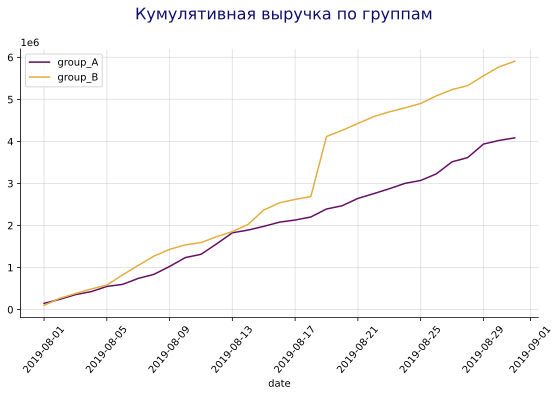

In [41]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.suptitle('Кумулятивная выручка по группам', fontsize=16, color='#0C0C6D')

cum_revenue_A.plot(x='date',
                   y='revenue',
                   ax=ax1,
                   color='#640F64',
                   label='group_A',
                   grid=True
                  )

cum_revenue_B.plot(x='date',
                   y='revenue',
                   ax=ax1,
                   color='#E3AD40',
                   label='group_B',
                   grid=True
                  )

fig.tight_layout()
plt.xticks(rotation=50)
plt.show()
# вывод линейного графика с кумулятивной выручкой по группам

Выручка **постепенно увеличивается** на протяжении всего срока тестирования. С 13 августа выручка группы B начинает расти с большим темпом и к концу месяца становится однозначно выше группы A.
*19 августа* виден резкий скачок графика группы B. Это может свидетельствовать об аномально больших заказах. 

In [42]:
orders_df.query('revenue == revenue.max()')
# вывод среза данных

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


Максимальная стоимость покупки была зафиксирована именно 19 августа.

### Построим график кумулятивного среднего чека по группам. 

In [43]:
cum_revenue_A['avg_bill'] = cum_revenue_A['revenue'] / cum_revenue_A['transactions']
cum_revenue_B['avg_bill'] = cum_revenue_B['revenue'] / cum_revenue_B['transactions']
# создание датафреймов для групп с кумулятивным средним чеком

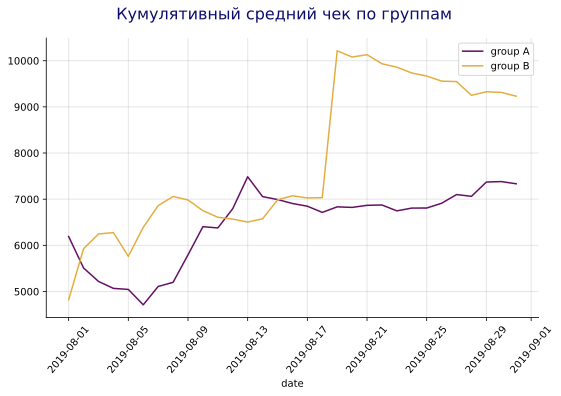

In [44]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.suptitle('Кумулятивный средний чек по группам', fontsize=16, color='#0C0C6D')

cum_revenue_A.plot('date',
                   'avg_bill',
                   ax=ax1,
                   color='#640F64',
                   label='group A',
                   grid=True
                  )

cum_revenue_B.plot('date',
                   'avg_bill',
                   ax=ax1,
                   color='#E3AD40',
                   label='group B',
                   grid=True
                  )

fig.tight_layout()
plt.xticks(rotation=50)
plt.show()
# вывод линейного графика с кумулятивным средним чеком по группам

До 20 августа показатель среднего чека был нестабилен, затем он установился примерно на одном уровне. После всплеска *19 августа*, как на графике кумулятивной выручки, средний чек группы B начал немного снижаться, оставаясь при этом **выше** среднего чека группы A.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

In [45]:
merged_cum_revenue = cum_revenue_A.merge(cum_revenue_B,
                                         left_on='date',
                                         right_on='date',
                                         how='left',
                                         suffixes=['A', 'B'])
# собираем данные в одном датафрейме

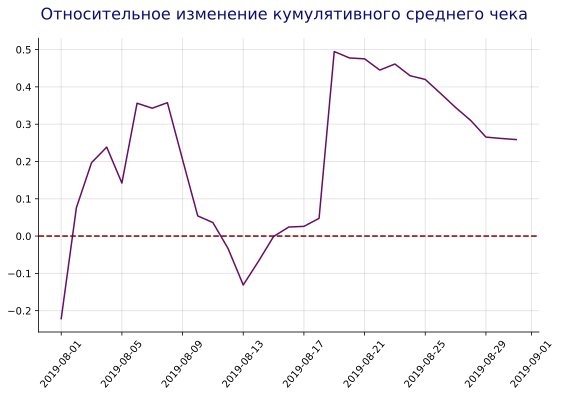

In [46]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.suptitle('Относительное изменение кумулятивного среднего чека', fontsize=16, color='#0C0C6D')

plt.plot(merged_cum_revenue['date'], 
        (merged_cum_revenue['avg_billB']) / (merged_cum_revenue['avg_billA']) - 1,
         color='#640F64')

plt.axhline(y=0, color='maroon', linestyle='--')

fig.tight_layout()
plt.xticks(rotation=50)
plt.show()
# вывод линейного графика с относительным изменением кумулятивного средниего чека

Как и в предыдущем случае, здесь заметен рост среднего чека с 1 по 8 августа, с 11 до 15 августа он был выше для группы A и потом до конца тестового промежутка времени **группа B** снова заняла лидирующую позицию. Всё также заказы, оформленные *19 августа*, отражаются на графике в виде резкого роста рассматриваемого показателя.

### Построим график кумулятивного среднего количества заказов на посетителя по группам.

In [47]:
cum_data['avg_transactions'] = cum_data['transactions'] / cum_data['visitors']
# считаем кумулятивное среднее количество заказов

In [48]:
cum_data_A = cum_data.query('group == "A"')
cum_data_B = cum_data.query('group == "B"')
# датафреймы с кумулятивным средним количеством заказов по группам

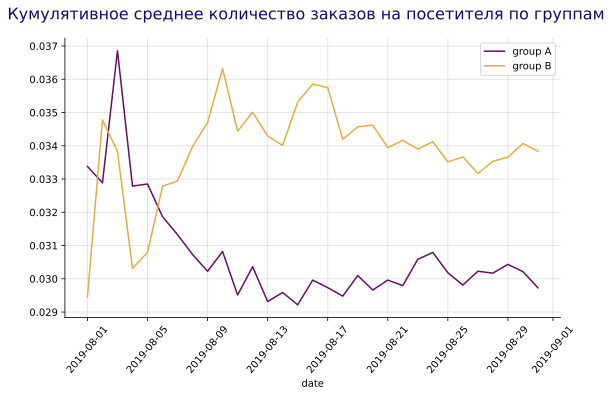

In [49]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.suptitle('Кумулятивное среднее количество заказов на посетителя по группам', fontsize=16, color='#0C0C6D')

cum_data_A.plot('date',
                'avg_transactions',
                 ax=ax1,
                 color='#640F64',
                 label='group A',
                 grid=True
                )

cum_data_B.plot('date',
                'avg_transactions',
                 ax=ax1,
                 color='#E3AD40',
                 label='group B',
                 grid=True
                )

fig.tight_layout()
plt.xticks(rotation=50)
plt.show()
# вывод линейного графика со средним количеством заказов на посетителя по группам

После фиксации сегмент B стал показывать величину **стабильно выше** среднего A.

В начале теста сегмент A имел более высокий показатель среднего количества заказов на посетителя за исключением интервала с 2 по 3 августа. Начиная с *4 августа*, метрика стала увеличиваться для группы B и всё больше снижаться для сегмента A. Затем, до конца месяца уровень среднего стал варьироваться в пределах  определённой величины для группы A и немного снизился для B.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

In [50]:
merged_cum_avg_transactions = cum_data_A[['date', 'avg_transactions']].merge(cum_data_B[['date', 'avg_transactions']],
                                                                             left_on='date', 
                                                                             right_on='date',
                                                                             how='left', 
                                                                             suffixes=['A', 'B'])
# собираем данные в одном датафрейме

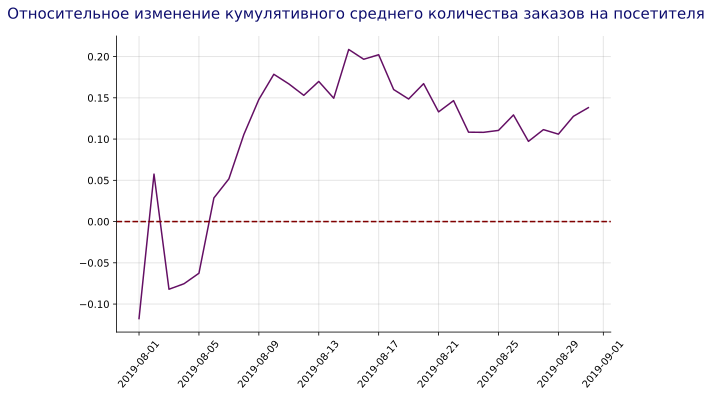

In [51]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.suptitle('Относительное изменение кумулятивного среднего количества заказов на посетителя', fontsize=15, color='#0C0C6D')

plt.plot(merged_cum_avg_transactions['date'], 
        (merged_cum_avg_transactions['avg_transactionsB']) / (merged_cum_avg_transactions['avg_transactionsA']) - 1,
         color='#640F64')

plt.axhline(y=0, color='maroon', linestyle='--')

fig.tight_layout()
plt.xticks(rotation=50)
plt.show()
# вывод линейного графика со средним количеством заказов на посетителя по группам

На графике хорошо виден момент, когда метрика **сегмента B** пошла вверх. Она достигла максимального уровня к *15 августа* и потом величина относительного изменения среднего количества заказов чуть просела.

### Построим точечный график количества заказов по пользователям.

In [52]:
orders_df.head(10)
# вывод первых 10 строк датафрейма orders_df

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


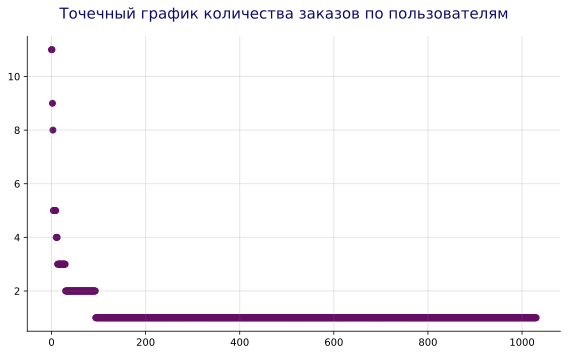

In [53]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.suptitle('Точечный график количества заказов по пользователям', fontsize=15, color='#0C0C6D')

x_list = pd.Series(range(0,len(transactions_per_visitors)))

plt.scatter(x_list,
            transactions_per_visitors['transactions_count'],               
            color='#640F64'
           )

fig.tight_layout()
plt.show()
# вывод точечного графика с количеством заказов на пользователя

Большинство пользователей оформляют по **1 заказу**. Клиенты с двумя покупками встречаются уже реже. А всё, что лежит *выше 3* — скорее всего аномальные значения.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [54]:
print(np.percentile(transactions_per_visitors['transactions_count'], [95, 97, 98, 99])) 
percentile_97_tr = np.percentile(transactions_per_visitors['transactions_count'], [95, 97, 98, 99])[1]
print('')
print(f'97-й перцентиль: {percentile_97_tr}')

[2. 2. 3. 4.]

97-й перцентиль: 2.0


Не более 1% посетителей оформляют больше 4 заказов и 98% совершают по **1 и 2 покупки**. Можно установить порог **аномальных значений** равный *3 заказам* (клиенты с 3 и более покупками не попадут в "очищенные" данные).

### Построим точечный график стоимостей заказов.

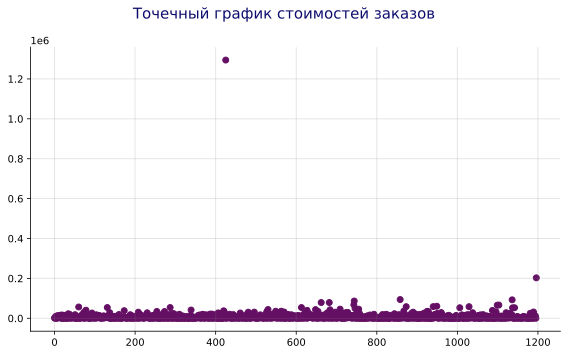

In [55]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.suptitle('Точечный график стоимостей заказов', fontsize=15, color='#0C0C6D')

x_list = pd.Series(range(0,len(orders_df)))

plt.scatter(x_list,
            orders_df['revenue'],               
            color='#640F64'
           )

fig.tight_layout()
plt.show()
# вывод точечного графика стоимостей заказов

На точечном графике видны **одиночные выбросы**, а заказы стоимостью меньше 100 тыс. слились в одну линию. Ограничим значения по оси Y, чтобы детальнее посмотреть на такие покупки. 

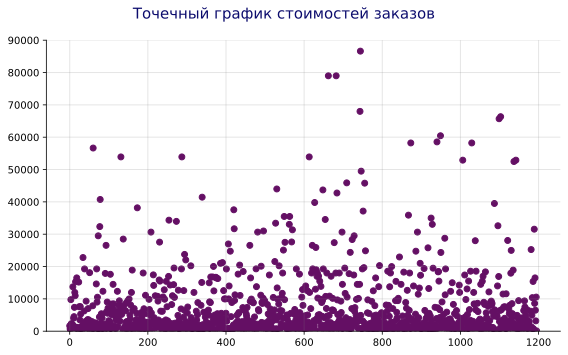

In [56]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.grid(which='major', linewidth=1, color='gray', alpha=0.2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.suptitle('Точечный график стоимостей заказов', fontsize=15, color='#0C0C6D')

x_list = pd.Series(range(0,len(orders_df)))

plt.scatter(x_list,
            orders_df['revenue'],               
            color='#640F64'
           )

plt.ylim([0, 90000])
fig.tight_layout()
plt.show()
# вывод точечного графика стоимостей заказов с ограничением по оси Y

Большинство пользователей совершают покупки на сумму **до 20-30 тыс.** Есть отдельные выбросы: заказы стоимостью *больше 50 тыс.* Найдём точную границу аномальных значений с помощью расчёта перцентилей.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [57]:
print(np.percentile(orders_df['revenue'], [95, 96, 97, 99])) 
percentile_97_rev = np.percentile(orders_df['revenue'], [95, 97, 98, 99])[1]
print('')
print(f'97-й перцентиль: {percentile_97_rev}')

[28000.  31382.  35485.  58233.2]

97-й перцентиль: 35485.0


Не более 3% заказов дороже 35 485 ед. и не более 1% дороже 58 234 ед. Будем считать покупки стоимостью *выше 35 тыс.* **аномалиями**.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

In [58]:
transactions_by_visitors_A = orders_df[orders_df['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
transactions_by_visitors_A.columns = ['visitorId', 'transactions']
# создание датафрейма с количеством заказов для каждого из пользователей группы A
transactions_by_visitors_B = orders_df[orders_df['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
transactions_by_visitors_B.columns = ['visitorId', 'transactions']
# создание датафрейма с количеством заказов для каждого из пользователей группы B

In [59]:
transactions_by_visitors_A.head()
# вывод первых 5 строк датафрейма transactions_by_visitors_A

,visitorId,transactions
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [60]:
visitors_A_daily = visitors_df[visitors_df['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']
# датафрейм с количеством посетителей на каждую дату в группе A
visitors_B_daily = visitors_df[visitors_df['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']
# датафрейм с количеством посетителей на каждую дату в группе B

In [61]:
visitors_A_daily.head()
# вывод первых 5 строк датафрейма visitors_A_daily

,date,visitors_per_date_A
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


Сохраним в переменные **sample_A и sample_B** выборки, где каждый элемент — число заказов определённого пользователя, в том числе ноль.

In [62]:
sample_A = pd.concat(
    [
        transactions_by_visitors_A['transactions'], 
        pd.Series(
            0, 
            index=np.arange(
                visitors_A_daily['visitors_per_date_A'].sum() - len(transactions_by_visitors_A['transactions'])
            ), 
            name='transactions',
        ),
    ], 
    axis=0,
)
sample_B = pd.concat(
    [
        transactions_by_visitors_B['transactions'], 
        pd.Series(
            0, 
            index=np.arange(
                visitors_B_daily['visitors_per_date_B'].sum() - len(transactions_by_visitors_B['transactions'])
            ), 
            name='transactions',
        ),
    ], 
    axis=0,
)
# создаём переменные с количеством заказов для каждого из посетителей по группам

In [63]:
transactions_A_daily = (
    orders_df[orders_df['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
transactions_A_daily.columns = ['date', 'transactions_per_date_A', 'revenue_per_date_A']
# создание датафрейма с количеством и стоимостью заказов группы A на каждую дату
transactions_B_daily = (
    orders_df[orders_df['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
transactions_B_daily.columns = ['date', 'transactions_per_date_B', 'revenue_per_date_B']
# создание датафрейма с количеством и стоимостью заказов группы B на каждую дату

Для расчёта статистической значимости применим непараметрический **тест Уилкоксона-Манна-Уитни**. Он используется в случае, когда в данных есть большие (по сравнению с нормальным распределением) выбросы и алгебраические метрики работают плохо. Главное отличие такого метода в том, что он учитывает ранги, — номера значений в упорядоченном ряду, никак не учитывая сами значения. 

Сформулируем **гипотезы** для проверки по **"сырым"** данным

**H0**: статистически значимых различий в среднем количестве заказов на посетителя нет

**H1**: статистически значимые различия в среднем количестве заказов на посетителя есть

Критический уровень значимости: *alpha = 0.05*

In [64]:
print("alpha:", 0.05)
print("p-value: {0:.3f}".format(st.mannwhitneyu(sample_A, sample_B)[1]))
# вывод p-value для сравнения среднего количества заказов между группами
print("Относительное различие в среднем: {0:.3f}".format((transactions_B_daily['transactions_per_date_B'].sum() / visitors_B_daily['visitors_per_date_B'].sum()) / (transactions_A_daily['transactions_per_date_A'].sum() / visitors_A_daily['visitors_per_date_A'].sum()) - 1))
# вывод относительного различия в среднем между группами (B к A)

alpha: 0.05
p-value: 0.017
Относительное различие в среднем: 0.138


P-value оказался **меньше** заданного уровня зачимости *alpha=5%*. Поэтому, нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов на посетителя между группами нет, отвергаем. Среднее по "сырым" данным между группами отличается, причём метрика группы B **больше** уровня группы A на *13.8%*.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем **гипотезы** для проверки по **"сырым"** данным

**H0**: статистически значимых различий в среднем чеке заказа нет

**H1**: статистически значимые различия в среднем чеке заказа есть

Критический уровень значимости: *alpha = 0.05*

In [65]:
print("alpha:", 0.05)
print('p-value: {0:.3f}'.format(st.mannwhitneyu(orders_df[orders_df['group']=='A']['revenue'], orders_df[orders_df['group']=='B']['revenue'])[1]))
# вывод p-value для сравнения среднего чека между группами
print('Относительное различие в среднем: {0:.3f}'.format(orders_df[orders_df['group']=='B']['revenue'].mean() / orders_df[orders_df['group']=='A']['revenue'].mean() - 1))
# вывод относительного различия в среднем между группами (B к A)

alpha: 0.05
p-value: 0.729
Относительное различие в среднем: 0.259


P-value оказался **больше** заданного уровня зачимости *alpha=5%*. Поэтому, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказа между группами нет, не отвергаем. Среднее по "сырым" данным между группами не отличается, при этом метрика группы B **больше** уровня группы A на *25.9%*.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Приступаем к подготовке очищенных от аномалий данных.

In [66]:
visitors_with_many_transactions = pd.concat([transactions_by_visitors_A[transactions_by_visitors_A['transactions'] > percentile_97_tr]['visitorId'], transactions_by_visitors_B[transactions_by_visitors_B['transactions'] > percentile_97_tr]['visitorId']], axis=0)
# срез Id пользователей с числом заказов больше 2
visitors_with_expensive_transactions = orders_df[orders_df['revenue'] > percentile_97_rev]['visitorId']
# срез Id пользователей, совершивших заказы дороже 35 000
abnormal_visitors = pd.concat([visitors_with_many_transactions, visitors_with_expensive_transactions], axis=0).drop_duplicates().sort_values()
abnormal_visitors.head()
# вывод первых 5 значений датафрейма abnormal_visitors

1099    148427295
18      199603092
23      237748145
37      249864742
684     358944393
Name: visitorId, dtype: int64

In [67]:
abnormal_visitors_list = list(abnormal_visitors)
len(abnormal_visitors_list)
# вывод числа аномальных пользователей 

51

In [68]:
len(list(set(intersect_visitors) & set(abnormal_visitors_list)))
# вывод числа аномальных пользователей, находящихся также в списке дублирующихся пользователей из пункта 5

16

In [69]:
print('Доля пользователей с аномальным поведением от общего числа клиентов: {0:.2%}'.format(abnormal_visitors.shape[0] / orders_df.groupby('visitorId')['visitorId'].nunique().shape[0]))

Доля пользователей с аномальным поведением от общего числа клиентов: 4.95%


Сформулируем **гипотезы** для проверки по **"очищенным"** данным

**H0**: статистически значимых различий в среднем количестве заказов на посетителя нет

**H1**: статистически значимые различия в среднем количестве заказов на посетителя есть

Критический уровень значимости: *alpha = 0.05*

In [70]:
sample_A_filtered = pd.concat(
    [
        transactions_by_visitors_A[
            np.logical_not(transactions_by_visitors_A['visitorId'].isin(abnormal_visitors))
        ]['transactions'],
        pd.Series(
            0,
            index=np.arange(
                visitors_A_daily['visitors_per_date_A'].sum() - len(transactions_by_visitors_A['transactions'])
            ), 
            name='transactions',
        ),
    ],
    axis=0,
)
sample_B_filtered = pd.concat(
    [
        transactions_by_visitors_B[
            np.logical_not(transactions_by_visitors_B['visitorId'].isin(abnormal_visitors))
        ]['transactions'],
        pd.Series(
            0,
            index=np.arange(
                visitors_B_daily['visitors_per_date_B'].sum() - len(transactions_by_visitors_B['transactions'])
            ), 
            name='transactions',
        ),
    ],
    axis=0,
)
# создаём переменные с количеством заказов для каждого из посетителей по группам без учёта аномальных пользователей

In [71]:
print('alpha:', 0.05)
print('p-value: {0:.3f}'.format(st.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
# вывод p-value для сравнения среднего количества заказов между группами
print('Относительное различие в среднем: {0:.3f}'.format((sample_B_filtered.mean()) / (sample_A_filtered.mean()) - 1))
# вывод относительного различия в среднем между группами (B к A)

alpha: 0.05
p-value: 0.010
Относительное различие в среднем: 0.179


P-value оказался **меньше** заданного уровня зачимости *alpha=5%*. Поэтому, нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов на посетителя между группами нет, отвергаем. Среднее по "очищенным" данным между группами отличается, при этом метрика группы B **больше** уровня группы A на *17.9%*.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Сформулируем **гипотезы** для проверки по **"очищенным"** данным

**H0**: статистически значимых различий в среднем чеке заказа нет

**H1**: статистически значимые различия в среднем чеке заказа есть

Критический уровень значимости: *alpha = 0.05*

In [72]:
print('alpha:', 0.05)
print(
    'p-value: {0:.3f}'.format(
        st.mannwhitneyu(
            orders_df[
                np.logical_and(
                    orders_df['group'] == 'A',
                    np.logical_not(orders_df['visitorId'].isin(abnormal_visitors)),
                )
            ]['revenue'],
            orders_df[
                np.logical_and(
                    orders_df['group'] == 'B',
                    np.logical_not(orders_df['visitorId'].isin(abnormal_visitors)),
                )
            ]['revenue'],
        )[1]
    )
)
# вывод p-value для сравнения среднего чека между группами
print(
    "Относительное различие в среднем: {0:.3f}".format(
        orders_df[
            np.logical_and(
                orders_df['group'] == 'B',
                np.logical_not(orders_df['visitorId'].isin(abnormal_visitors)),
            )
        ]['revenue'].mean()
        / orders_df[
            np.logical_and(
                orders_df['group'] == 'A',
                np.logical_not(orders_df['visitorId'].isin(abnormal_visitors)),
            )
        ]['revenue'].mean()
        - 1
    )
)
# вывод относительного различия в среднем между группами (B к A)

alpha: 0.05
p-value: 0.878
Относительное различие в среднем: 0.020


P-value оказался **больше** заданного уровня зачимости *alpha=5%*. Поэтому, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказа между группами нет, не отвергаем. Среднее по "очищенным" данным между группами не отличается, при этом метрика группы B **больше** уровня группы A всего на *2.0%*.

### Решение по результатам теста:

Как до, так и после удаления аномальных пользователей тесты продемонстрировали статистически значимую **разницу в среднем количестве заказов на посетителя** для обеих групп. В первом случае прирост составил *13.8%*, а во втором — *17.9%*.

Также анализ на основе "сырых" и "очищенных" данных **не вывел отличия в среднем чеке заказа** между сегментами, хотя без отсечения аномалий средний чек группы B был больше на *25.9%* (скорее всего на это повлияли выбросы), а после очистки данных он превысил величину среднего A всего лишь на *2.0%*.


На основе проведённого анализа можно заключить, что группа B показала лучшие результаты и следует остановить тест и зафиксировать **победу группы B**. Несмотря на незначительную разницу в среднем чеке между группами, показатель среднего количества заказов на посетителя сегмента B оказался выше среднего группы A на *17.9%*, что свидетельствует об **эффективности нововведения**.